### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import itertools

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

Data:

HR Analytics: Job Change of Data Scientists
Predict who will move to a new job 

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv


Features

    enrollee_id : Unique ID for candidate

    city: City code

    city_ development _index : Developement index of the city (scaled)

    gender: Gender of candidate

    relevent_experience: Relevant experience of candidate

    enrolled_university: Type of University course enrolled if any

    education_level: Education level of candidate

    major_discipline :Education major discipline of candidate

    experience: Candidate total experience in years

    company_size: No of employees in current employer's company

    company_type : Type of current employer

    lastnewjob: Difference in years between previous job and current job

    training_hours: training hours completed

    target: 0 – Not looking for job change, 1 – Looking for a job change

Inspiration

    Predict the probability of a candidate will work for the company



In [2]:
df = pd.read_csv("aug_train.csv")

df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [3]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [4]:
df.describe(include='object')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
for c in df.columns:
    print (c, ': Total unique = ', len(df[c].unique()), df[c].unique(), '\n')

enrollee_id : Total unique =  19158 [ 8949 29725 11561 ... 24576  5756 23834] 

city : Total unique =  123 ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city

In [7]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [8]:
t_u_dict_low = {
    '50-99':50, '<10':0, '10000+':10000, '5000-9999':5000, '1000-4999':1000, '10/49':10, '100-500':100,
    '500-999':500, np.NaN:np.NaN
                }
t_u_dict_high = {
    '50-99':99, '<10':9, '10000+':20000, '5000-9999':9999, '1000-4999':4999, '10/49':49, '100-500':500,
    '500-999':999, np.NaN:np.NaN
                }

t_u_last_new_job = {
    '1':1, '>4':5, 'never':0, '4':4, '3':3, '2':2, np.NaN:np.NaN
                    }
# def total_unique_low(x):
    

In [9]:
df['relevent_experience'] = df['relevent_experience'].apply(lambda x: 0 if x == 'No relevent experience' else 1)
df['experience'] = df['experience'].apply(lambda x: 21 if x == '>20' else (0 if x == '<1' else (np.NaN if pd.isnull(x) else (int(x)))))

In [10]:
df['company_size_low'] = df['company_size'].apply(lambda x: t_u_dict_low[x])
df['company_size_high'] = df['company_size'].apply(lambda x: t_u_dict_high[x])
df['last_new_job'] = df['last_new_job'].apply(lambda x: t_u_last_new_job[x])

In [11]:
df = df.drop(['company_size'], axis=1)

In [12]:
for c in df.columns:
    print (c, ': Total unique = ', len(df[c].unique()), df[c].unique(), '\n')

enrollee_id : Total unique =  19158 [ 8949 29725 11561 ... 24576  5756 23834] 

city : Total unique =  123 ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city

In [13]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_type', 'last_new_job',
       'training_hours', 'target', 'company_size_low', 'company_size_high'],
      dtype='object')

In [14]:
target_column = ['target']

categorical_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
                    'major_discipline', 'company_type'
                   ]

continuous_cols = ['city_development_index', 'experience', 'last_new_job', 'training_hours',
                   'company_size_low', 'company_size_high'
                  ]

Заполняем пустые значения в категориальных колонках

In [15]:
df2 = df[categorical_cols].fillna('nodata')
df2

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type
0,city_103,Male,1,no_enrollment,Graduate,STEM,nodata
1,city_40,Male,0,no_enrollment,Graduate,STEM,Pvt Ltd
2,city_21,nodata,0,Full time course,Graduate,STEM,nodata
3,city_115,nodata,0,nodata,Graduate,Business Degree,Pvt Ltd
4,city_162,Male,1,no_enrollment,Masters,STEM,Funded Startup
...,...,...,...,...,...,...,...
19153,city_173,Male,0,no_enrollment,Graduate,Humanities,nodata
19154,city_103,Male,1,no_enrollment,Graduate,STEM,nodata
19155,city_103,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd
19156,city_65,Male,1,no_enrollment,High School,nodata,Pvt Ltd


In [16]:
df3 = pd.concat([df[continuous_cols], df2, df[target_column]], axis=1)

In [17]:
df3

,city_development_index,experience,last_new_job,training_hours,company_size_low,company_size_high,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,target
0,0.920,21.0,1.0,36,NaN,NaN,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,1.0
1,0.776,15.0,5.0,47,50.0,99.0,city_40,Male,0,no_enrollment,Graduate,STEM,Pvt Ltd,0.0
2,0.624,5.0,0.0,83,NaN,NaN,city_21,nodata,0,Full time course,Graduate,STEM,nodata,0.0
3,0.789,0.0,0.0,52,NaN,NaN,city_115,nodata,0,nodata,Graduate,Business Degree,Pvt Ltd,1.0
4,0.767,21.0,4.0,8,50.0,99.0,city_162,Male,1,no_enrollment,Masters,STEM,Funded Startup,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,14.0,1.0,42,NaN,NaN,city_173,Male,0,no_enrollment,Graduate,Humanities,nodata,1.0
19154,0.920,14.0,4.0,52,NaN,NaN,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,1.0
19155,0.920,21.0,4.0,44,50.0,99.0,city_103,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,0.0
19156,0.802,0.0,2.0,97,500.0,999.0,city_65,Male,1,no_enrollment,High School,nodata,Pvt Ltd,0.0


In [18]:
df3.to_csv('df3.csv', index=False)

Feature ingeneering

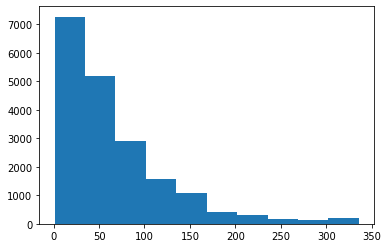

In [19]:
plt.hist(df3['training_hours'])
plt.show()

In [20]:
df3['training_hours_log'] = np.log(df3['training_hours'])

<function matplotlib.pyplot.show(close=None, block=None)>

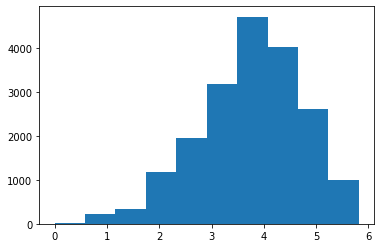

In [21]:
plt.hist(df3['training_hours_log'])
plt.show

C:\Users\LMAXL\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\LMAXL\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


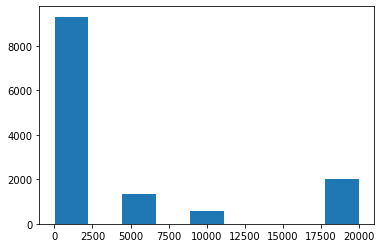

In [22]:
plt.hist(df3['company_size_high'], bins = 9)
plt.show()

In [23]:
df3['company_category'] = df3['company_size_high'].apply(lambda x: int(0) if x < 2500 else ('nodata' if pd.isnull(x) else int(1)))

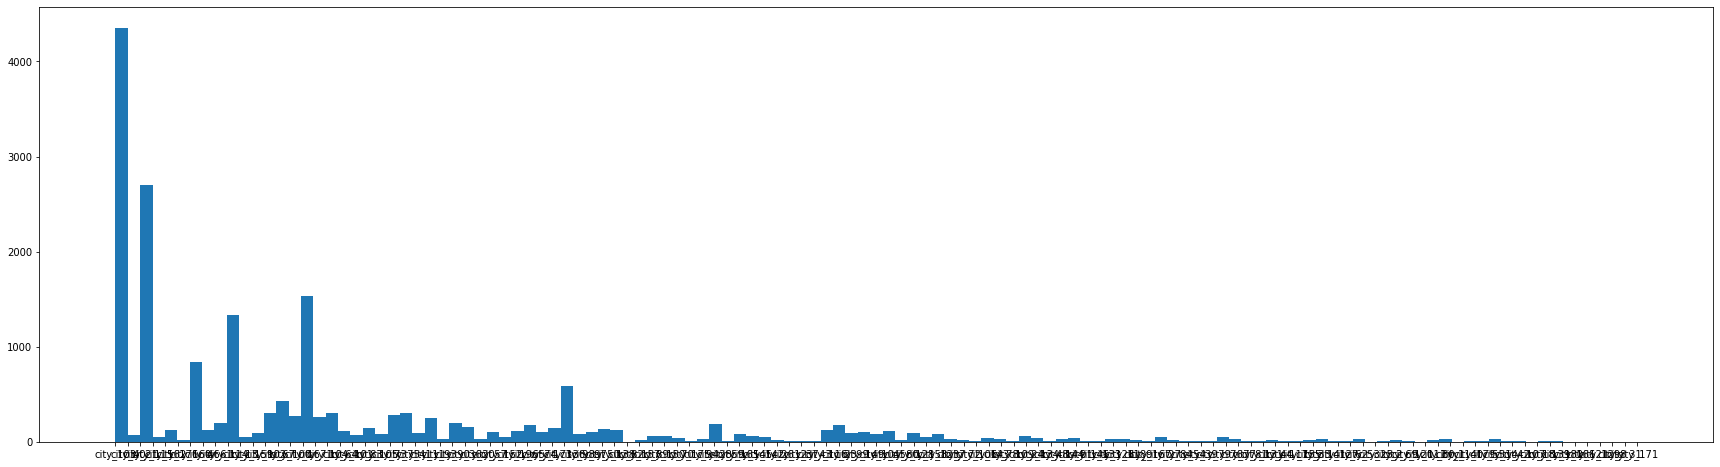

In [24]:
plt.figure(figsize=(30, 8))
plt.hist(df3.city, bins=123)
plt.show()

In [25]:
df3

,city_development_index,experience,last_new_job,training_hours,company_size_low,company_size_high,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,target,training_hours_log,company_category
0,0.920,21.0,1.0,36,NaN,NaN,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,1.0,3.583519,nodata
1,0.776,15.0,5.0,47,50.0,99.0,city_40,Male,0,no_enrollment,Graduate,STEM,Pvt Ltd,0.0,3.850148,0
2,0.624,5.0,0.0,83,NaN,NaN,city_21,nodata,0,Full time course,Graduate,STEM,nodata,0.0,4.418841,nodata
3,0.789,0.0,0.0,52,NaN,NaN,city_115,nodata,0,nodata,Graduate,Business Degree,Pvt Ltd,1.0,3.951244,nodata
4,0.767,21.0,4.0,8,50.0,99.0,city_162,Male,1,no_enrollment,Masters,STEM,Funded Startup,0.0,2.079442,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,14.0,1.0,42,NaN,NaN,city_173,Male,0,no_enrollment,Graduate,Humanities,nodata,1.0,3.737670,nodata
19154,0.920,14.0,4.0,52,NaN,NaN,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,1.0,3.951244,nodata
19155,0.920,21.0,4.0,44,50.0,99.0,city_103,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,0.0,3.784190,0
19156,0.802,0.0,2.0,97,500.0,999.0,city_65,Male,1,no_enrollment,High School,nodata,Pvt Ltd,0.0,4.574711,0


In [26]:
# убираем 'company_size_low', 'company_size_high', добавляем 'company_category', 'training_hours_log'

categorical_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
                    'major_discipline', 'company_type', 'company_category' 
                   ]

continuous_cols = ['city_development_index', 'experience', 'last_new_job', 'training_hours', 'training_hours_log'
                  ]

In [27]:
from catboost import Pool, CatBoostClassifier

In [28]:
df3[categorical_cols + continuous_cols]

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log
0,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,nodata,0.920,21.0,1.0,36,3.583519
1,city_40,Male,0,no_enrollment,Graduate,STEM,Pvt Ltd,0,0.776,15.0,5.0,47,3.850148
2,city_21,nodata,0,Full time course,Graduate,STEM,nodata,nodata,0.624,5.0,0.0,83,4.418841
3,city_115,nodata,0,nodata,Graduate,Business Degree,Pvt Ltd,nodata,0.789,0.0,0.0,52,3.951244
4,city_162,Male,1,no_enrollment,Masters,STEM,Funded Startup,0,0.767,21.0,4.0,8,2.079442
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,city_173,Male,0,no_enrollment,Graduate,Humanities,nodata,nodata,0.878,14.0,1.0,42,3.737670
19154,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,nodata,0.920,14.0,4.0,52,3.951244
19155,city_103,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,0,0.920,21.0,4.0,44,3.784190
19156,city_65,Male,1,no_enrollment,High School,nodata,Pvt Ltd,0,0.802,0.0,2.0,97,4.574711


In [29]:
# initialize data
train_data, test_data, train_label, test_label = train_test_split(df3[categorical_cols + continuous_cols],
                                                                  df3[target_column], random_state=68)


# initialize Pool
train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=categorical_cols)
test_pool = Pool(test_data, 
                 cat_features=categorical_cols) 

# specify the training parameters 
model = CatBoostClassifier(iterations=2000,
                           depth=3,
                           learning_rate=1,
                           loss_function='Logloss',
                           early_stopping_rounds=50,
                           verbose=1000,
                           random_state=68,
                           one_hot_max_size=50
                          )


# model = CatBoostRegressor(iterations=2000, 
#                           depth=2, 
#                           learning_rate=1, 
#                           loss_function='RMSE',
#                           early_stopping_rounds=50,
#                           verbose=50,
#                           random_state=68
#                          )
#train the model
model.fit(train_pool)

# model.fit(train_data, train_labels)

# make the prediction using the resulting model
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.4751205	total: 171ms	remaining: 5m 42s
1000:	learn: 0.2796483	total: 22.3s	remaining: 22.3s
1999:	learn: 0.2126386	total: 44.6s	remaining: 0us
class =  [0. 0. 0. ... 0. 1. 0.]
proba =  [[0.94372934 0.05627066]
 [0.93342737 0.06657263]
 [0.92951522 0.07048478]
 ...
 [0.94157242 0.05842758]
 [0.41390937 0.58609063]
 [0.84652713 0.15347287]]


In [30]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix

In [31]:
roc_auc_score(test_label,preds_proba[:,1])

0.7424292547397148

In [32]:
precision, recall, thresholds = precision_recall_curve(test_label,preds_proba[:,1])
auc(recall, precision) #, reorder=True

0.4779975941101782

In [33]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.264640, F-Score=0.555, Precision=0.488, Recall=0.644


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3059  550]
 [ 576  605]]


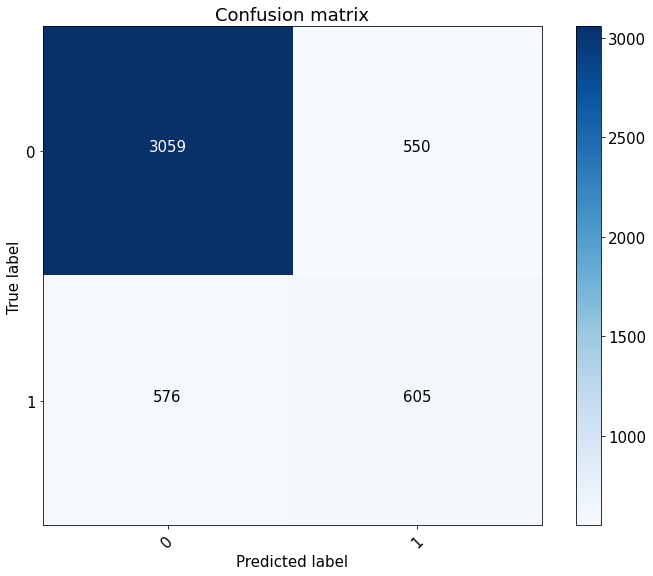

In [35]:
# preds = pipeline.predict_proba(X_test)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, preds)
# fscore = (2 * precision * recall) / (precision + recall)
# # locate the index of the largest f score
# ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

# #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(test_label, preds_class)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [36]:
models_results = {
    'Classifier': [],
    'f1': [],
    'roc auc': [],
    'recall': [],
    'precision': [],
    'pr auc': []
    }

In [37]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve

def evaluate_results(classificator, y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    pr_auc = auc(recall, precision)
    print("pr auc: %.2f%%" % (pr_auc * 100.0))
    
    models_results['Classifier'].append(classificator)
    models_results['f1'].append(f1)
    models_results['roc auc'].append(roc)
    models_results['recall'].append(rec)
    models_results['precision'].append(prc)
    models_results['pr auc'].append(pr_auc)
    
    
evaluate_results('Standard binary',test_label,preds_class)

Classification results:
f1: 51.80%
roc: 67.99%
recall: 51.23%
precision: 52.38%
pr auc: 57.82%


### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [38]:
mod_data = df3[categorical_cols + continuous_cols + target_column].copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 1195/4777 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [39]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    17963
 1     1195
Name: class_test, dtype: int64


* We now have just 478 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col -2 still holds the actual label

In [40]:
mod_data.head(10)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log,target,class_test
0,city_103,Male,1,no_enrollment,Graduate,STEM,nodata,nodata,0.920,21.0,1.0,36,3.583519,1.0,-1
1,city_40,Male,0,no_enrollment,Graduate,STEM,Pvt Ltd,0,0.776,15.0,5.0,47,3.850148,0.0,-1
2,city_21,nodata,0,Full time course,Graduate,STEM,nodata,nodata,0.624,5.0,0.0,83,4.418841,0.0,-1
3,city_115,nodata,0,nodata,Graduate,Business Degree,Pvt Ltd,nodata,0.789,0.0,0.0,52,3.951244,1.0,1
4,city_162,Male,1,no_enrollment,Masters,STEM,Funded Startup,0,0.767,21.0,4.0,8,2.079442,0.0,-1
5,city_176,nodata,1,Part time course,Graduate,STEM,nodata,nodata,0.764,11.0,1.0,24,3.178054,1.0,-1
6,city_160,Male,1,no_enrollment,High School,nodata,Funded Startup,0,0.920,5.0,1.0,24,3.178054,0.0,-1
7,city_46,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,0,0.762,13.0,5.0,18,2.890372,1.0,-1
8,city_103,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,0,0.920,7.0,1.0,46,3.828641,1.0,-1
9,city_103,nodata,1,no_enrollment,Graduate,STEM,Pvt Ltd,1,0.920,17.0,5.0,123,4.812184,0.0,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [41]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [42]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(1195, 15) (1195, 15)


In [43]:
sample_train.iloc[:,:-2]

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log
14133,city_21,Male,1,no_enrollment,Masters,STEM,nodata,nodata,0.624,6.0,2.0,160,5.075174
16809,city_76,Male,0,no_enrollment,Graduate,STEM,nodata,1,0.698,1.0,1.0,70,4.248495
9148,city_103,Male,1,no_enrollment,Graduate,STEM,NGO,0,0.920,18.0,4.0,157,5.056246
9038,city_99,nodata,0,Full time course,Graduate,nodata,nodata,nodata,0.915,5.0,1.0,18,2.890372
10477,city_16,nodata,0,no_enrollment,High School,nodata,nodata,1,0.910,6.0,1.0,7,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15836,city_21,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,1,0.624,5.0,2.0,196,5.278115
2819,city_162,Male,1,Full time course,Graduate,STEM,Pvt Ltd,0,0.767,15.0,3.0,84,4.430817
15634,city_149,Male,1,no_enrollment,Graduate,Arts,nodata,nodata,0.689,4.0,4.0,72,4.276666
9613,city_116,Male,0,Full time course,Graduate,STEM,Pvt Ltd,nodata,0.743,3.0,0.0,47,3.850148


In [44]:
model = CatBoostClassifier(iterations=2000,
                           depth=3,
                           learning_rate=1,
                           loss_function='Logloss',
                           early_stopping_rounds=50,
                           verbose=1000,
                           random_state=68,
                           one_hot_max_size=50,
                           cat_features=categorical_cols
                          )

model.fit(sample_train.iloc[:,:-2], 
          sample_train.iloc[:,-2])
y_predict = model.predict(sample_test.iloc[:,:-2])


0:	learn: 0.5465872	total: 10.3ms	remaining: 20.6s
1000:	learn: 0.0472835	total: 11.7s	remaining: 11.7s
1999:	learn: 0.0256760	total: 23.1s	remaining: 0us


In [45]:
evaluate_results('PU learning 25%', sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 44.14%
roc: 67.13%
recall: 76.12%
precision: 31.09%
pr auc: 55.98%


сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [46]:
pd.DataFrame(data=models_results).sort_values('pr auc', ascending=False)

,Classifier,f1,roc auc,recall,precision,pr auc
0,Standard binary,0.517979,0.679940,0.512278,0.523810,0.578169
1,PU learning 25%,0.441448,0.671284,0.761176,0.310869,0.559758


## поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [47]:
# leave just 10% of the positives marked
pos_sample_len = int(np.ceil(0.10 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 478/4777 as positives and unlabeling the rest


In [48]:
mod_data.head(3)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log,target,class_test
15357,city_57,Male,1,no_enrollment,Graduate,STEM,Early Stage Startup,0,0.866,16.0,1.0,58,4.060443,0.0,-1
3502,city_26,Male,1,nodata,Graduate,STEM,Pvt Ltd,0,0.698,14.0,2.0,32,3.465736,0.0,-1
7254,city_28,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,1,0.939,21.0,5.0,91,4.510860,0.0,-1


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [49]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    18680
 1      478
Name: class_test, dtype: int64


* We now have just 1195 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col -2 still holds the actual label

In [50]:
mod_data.head(10)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log,target,class_test
15357,city_57,Male,1,no_enrollment,Graduate,STEM,Early Stage Startup,0,0.866,16.0,1.0,58,4.060443,0.0,-1
3502,city_26,Male,1,nodata,Graduate,STEM,Pvt Ltd,0,0.698,14.0,2.0,32,3.465736,0.0,-1
7254,city_28,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,1,0.939,21.0,5.0,91,4.510860,0.0,-1
14271,city_11,Male,0,Full time course,Graduate,STEM,nodata,nodata,0.550,2.0,0.0,10,2.302585,1.0,-1
5451,city_136,Male,1,no_enrollment,Graduate,STEM,nodata,nodata,0.897,2.0,2.0,66,4.189655,0.0,-1
760,city_136,Male,0,nodata,nodata,nodata,nodata,nodata,0.897,1.0,0.0,24,3.178054,0.0,-1
2238,city_21,nodata,1,no_enrollment,Masters,STEM,Pvt Ltd,0,0.624,9.0,1.0,150,5.010635,0.0,-1
13048,city_28,Male,1,no_enrollment,Graduate,STEM,Funded Startup,0,0.939,21.0,1.0,72,4.276666,0.0,-1
16758,city_101,Male,1,Part time course,Graduate,STEM,Pvt Ltd,0,0.558,3.0,2.0,330,5.799093,0.0,-1
10216,city_114,Male,1,no_enrollment,Graduate,Humanities,Pvt Ltd,0,0.926,21.0,5.0,14,2.639057,0.0,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [51]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [52]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(478, 15) (478, 15)


In [53]:
sample_train.iloc[:,:-2]

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log
12653,city_21,nodata,1,Full time course,Graduate,STEM,Pvt Ltd,1,0.624,5.0,1.0,74,4.304065
18517,city_103,Male,0,Full time course,Graduate,STEM,nodata,nodata,0.920,6.0,1.0,166,5.111988
14243,city_160,Male,1,no_enrollment,Graduate,Business Degree,nodata,nodata,0.920,21.0,5.0,31,3.433987
17062,city_159,nodata,0,Full time course,Graduate,STEM,nodata,nodata,0.843,1.0,0.0,40,3.688879
10938,city_160,Male,0,Full time course,High School,nodata,nodata,nodata,0.920,3.0,1.0,90,4.499810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,city_21,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,nodata,0.624,3.0,1.0,52,3.951244
18468,city_145,Male,1,no_enrollment,Graduate,STEM,nodata,nodata,0.555,9.0,1.0,24,3.178054
140,city_90,Female,0,Full time course,Masters,STEM,nodata,nodata,0.698,5.0,4.0,21,3.044522
12593,city_46,nodata,1,no_enrollment,Graduate,STEM,nodata,nodata,0.762,9.0,1.0,65,4.174387


In [54]:
# model = CatBoostClassifier(iterations=2000,
#                            depth=3,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            early_stopping_rounds=50,
#                            verbose=1000,
#                            random_state=68,
#                            one_hot_max_size=50,
#                            cat_features=categorical_cols
#                           )

model.fit(sample_train.iloc[:,:-2], 
          sample_train.iloc[:,-2])
y_predict = model.predict(sample_test.iloc[:,:-2])


0:	learn: 0.5522816	total: 10.6ms	remaining: 21.2s
1000:	learn: 0.0160648	total: 10.3s	remaining: 10.3s
1999:	learn: 0.0134396	total: 20.3s	remaining: 0us


In [55]:
evaluate_results('PU learning 10%', sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 48.20%
roc: 67.23%
recall: 77.38%
precision: 35.00%
pr auc: 58.79%


In [56]:
# leave just 50% of the positives marked
pos_sample_len = int(np.ceil(0.50 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 2389/4777 as positives and unlabeling the rest


In [57]:
mod_data.head(3)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log,target,class_test
14990,city_16,Female,1,Full time course,Graduate,STEM,Public Sector,1,0.910,5.0,1.0,114,4.736198,0.0,-1
11914,city_103,Male,1,Part time course,Graduate,STEM,Pvt Ltd,1,0.920,11.0,2.0,174,5.159055,0.0,-1
8615,city_64,Male,1,no_enrollment,Masters,STEM,Pvt Ltd,0,0.666,21.0,1.0,24,3.178054,0.0,-1


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [58]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    16769
 1     2389
Name: class_test, dtype: int64


* We now have just 1195 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col -2 still holds the actual label

In [59]:
mod_data.head(10)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log,target,class_test
14990,city_16,Female,1,Full time course,Graduate,STEM,Public Sector,1,0.910,5.0,1.0,114,4.736198,0.0,-1
11914,city_103,Male,1,Part time course,Graduate,STEM,Pvt Ltd,1,0.920,11.0,2.0,174,5.159055,0.0,-1
8615,city_64,Male,1,no_enrollment,Masters,STEM,Pvt Ltd,0,0.666,21.0,1.0,24,3.178054,0.0,-1
1450,city_36,Male,1,no_enrollment,Graduate,STEM,Funded Startup,0,0.893,9.0,1.0,26,3.258097,0.0,-1
2699,city_21,nodata,1,no_enrollment,Graduate,STEM,nodata,nodata,0.624,5.0,1.0,18,2.890372,1.0,1
3773,city_21,nodata,1,Full time course,Graduate,STEM,Pvt Ltd,1,0.624,9.0,1.0,102,4.624973,1.0,1
18856,city_21,nodata,1,no_enrollment,Graduate,STEM,Pvt Ltd,1,0.624,7.0,1.0,17,2.833213,0.0,-1
3475,city_53,Male,1,Part time course,Graduate,STEM,Pvt Ltd,nodata,0.740,14.0,5.0,12,2.484907,0.0,-1
8542,city_21,nodata,1,Full time course,Graduate,STEM,nodata,nodata,0.624,3.0,0.0,28,3.332205,0.0,-1
8243,city_61,Male,0,no_enrollment,Graduate,STEM,Pvt Ltd,0,0.913,1.0,0.0,52,3.951244,0.0,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [60]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [61]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(2389, 15) (2389, 15)


In [62]:
sample_train.iloc[:,:-2]

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_type,company_category,city_development_index,experience,last_new_job,training_hours,training_hours_log
6091,city_16,Male,0,no_enrollment,Primary School,nodata,nodata,nodata,0.910,3.0,0.0,77,4.343805
14778,city_57,Male,1,no_enrollment,Graduate,STEM,nodata,nodata,0.866,17.0,1.0,10,2.302585
13587,city_16,Male,1,no_enrollment,High School,nodata,Pvt Ltd,0,0.910,0.0,5.0,57,4.043051
17381,city_160,Male,0,Full time course,Graduate,STEM,nodata,nodata,0.920,4.0,1.0,42,3.737670
14664,city_160,Male,0,Full time course,High School,nodata,Pvt Ltd,1,0.920,5.0,1.0,14,2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17711,city_123,nodata,1,no_enrollment,Graduate,Other,nodata,nodata,0.738,12.0,5.0,17,2.833213
7784,city_21,nodata,1,Full time course,Masters,STEM,nodata,nodata,0.624,6.0,1.0,6,1.791759
2592,city_103,Male,1,no_enrollment,Graduate,STEM,Pvt Ltd,1,0.920,21.0,2.0,54,3.988984
13672,city_21,Other,0,no_enrollment,Graduate,STEM,nodata,nodata,0.624,4.0,0.0,190,5.247024


In [63]:
# model = CatBoostClassifier(iterations=2000,
#                            depth=3,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            early_stopping_rounds=50,
#                            verbose=1000,
#                            random_state=68,
#                            one_hot_max_size=50,
#                            cat_features=categorical_cols
#                           )

model.fit(sample_train.iloc[:,:-2], 
          sample_train.iloc[:,-2])
y_predict = model.predict(sample_test.iloc[:,:-2])


0:	learn: 0.5521768	total: 11.8ms	remaining: 23.5s
1000:	learn: 0.1736926	total: 13.5s	remaining: 13.5s
1999:	learn: 0.0827769	total: 27s	remaining: 0us


In [64]:
evaluate_results('PU learning 50%', sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 38.10%
roc: 69.51%
recall: 75.17%
precision: 25.51%
pr auc: 52.10%


сравним качество всех решений:

In [65]:
pd.DataFrame(data=models_results).sort_values('pr auc', ascending=False)

,Classifier,f1,roc auc,recall,precision,pr auc
2,PU learning 10%,0.482030,0.672344,0.773770,0.350049,0.587923
0,Standard binary,0.517979,0.679940,0.512278,0.523810,0.578169
1,PU learning 25%,0.441448,0.671284,0.761176,0.310869,0.559758
3,PU learning 50%,0.380964,0.695073,0.751721,0.255131,0.520985


Вывод - как ни странно, но точность падает при бОльшем количестве размеченных Positive. В данном примере при разметке 10% точность наилучшая, даже выше чем при полностью размеченном датасете

Роман, так и должно быть? нет ли где-то ошибки?